# Assignment 3

\- Yash Gupta (190997)

### Part 1: 25 marks

Fill in the partially complete lines of code in the file temporal_context_model_empty.m to make a temporal context model of memory retrieval that retrieves about 7 items from an encoded list efficiently.

This should not be very challenging if you've followed the concept of the TCM in class. 

The temporal context model assumes that the past becomes increasingly dissimilar to the future, so that memories become harder to retrieve the farther away in the past they are. 

We are going to model the world as a set of N continuous-valued features. We will model observations of states of the world as samples from N Gaussians with time-varying means and fixed variance. For simplicity, we will assume that agents change nothing in the world.

In [121]:
import numpy as np
from matplotlib import pyplot as plt
from numpy import random as rand
from sklearn.mixture import GaussianMixture

In [122]:
def draw_from_a_dist(p):
    if np.sum(p) == 0:
        p = 0.05 * np.ones(len(p))
    p /= np.sum(p)
    idx = np.where(rand.random(1) - np.cumsum(p) < 0)
    sample = np.min(idx)
    out = np.zeros(len(p))
    out[sample] = 1
    return out

In [123]:
N_WORLD_FEATURES = 5
N_ITEMS = 10
ENCODING_TIME = 500
TEST_TIME = 20

First we will fix the presentation schedule; We'll assuming its random. 

In [124]:
schedule = np.column_stack((np.sort(np.round(rand.random(N_ITEMS) * ENCODING_TIME)), np.arange(N_ITEMS)))
schedule_load = ENCODING_TIME / np.median(np.diff(schedule[:, 0])) # variable important for parts 2,3 of assignment
encoding = np.zeros((N_ITEMS, N_WORLD_FEATURES + 1))

world_m = np.array([1, 2, 1, 2, 3], dtype=float)
world_var = 1
delta = 0.05
beta_param = 0.001
m = 0

Simulating encoding:

In [125]:
for time in range(ENCODING_TIME):
    world_m += delta
    world = rand.normal(world_m, world_var)
    # any item I want to encode in memory, I encode in association with the
    # state of the world at that time.
    if m < N_ITEMS:
        if time == schedule[m, 0]:
            encoding[m, :] = np.append(world, m) # encode into the encoding vector
            m += 1

Simulating retrieval using SAM, but with a bijective image-item mapping:

In [140]:
out = np.zeros(TEST_TIME)
while time < ENCODING_TIME + TEST_TIME:
    # the state of the world is the retrieval cue
    world_m += delta
    world = rand.normal(world_m, world_var) # model world evolution
    soa = np.zeros(N_ITEMS)
    for m in range(N_ITEMS):
        soa[m] = np.dot(encoding[m], np.append(world, m)) # finding association strengths
    soa /= np.linalg.norm(soa) # normalize
    out[time - ENCODING_TIME] = np.where(draw_from_a_dist(soa) > 0)[0]
    time += 1

success = len(np.unique(out)) # success is number of unique retrievals

Humans can retrieve about 7 items effectively from memory. We want this model to behave like humans. 

Let's check the average success over 100 iterations. 

In [127]:
success_sum = 0
num_iter = 100

for i in range(num_iter):
    schedule = np.column_stack((np.sort(np.round(rand.random(N_ITEMS) * ENCODING_TIME)), np.arange(N_ITEMS)))
    schedule_load = ENCODING_TIME / np.median(np.diff(schedule[:, 0]))
    encoding = np.zeros((N_ITEMS, N_WORLD_FEATURES + 1))

    world_m = np.array([1, 2, 1, 2, 3], dtype=float)
    world_var = 1
    delta = 0.05
    beta_param = 0.001
    m = 0

    for time in range(ENCODING_TIME):
        world_m += delta
        world = rand.normal(world_m, world_var)
        if m < N_ITEMS:
            if time == schedule[m, 0]:
                encoding[m, :] = np.append(world, m)
                m += 1

    out = np.zeros(TEST_TIME)
    while time < ENCODING_TIME + TEST_TIME:
        world_m += delta
        world = rand.normal(world_m, world_var)
        soa = np.zeros(N_ITEMS)
        for m in range(N_ITEMS):
            soa[m] = np.dot(encoding[m], np.append(world, m))
        soa /= np.linalg.norm(soa)
        out[time - ENCODING_TIME] = np.where(draw_from_a_dist(soa) > 0)[0]
        time += 1

    success = len(np.unique(out))
    success_sum += success

avg_success = success_sum / num_iter
print(f'Average success over {num_iter} iterations: {avg_success}')

Average success over 100 iterations: 7.76


Hence, our model behaves like humans as it retrieves more than 7 items from an encoded list efficiently, on average. 

### Part 2: 25 marks

Alongside the TCM you have implemented, you have also implemented assumptions about the physics of the world. Namely, you have assumed that the world can be represented as a set of draws from N independent Gaussians, and that the means of these Gaussians evolve over time linearly. Now we change this. We assume that the world contains context changes, and represent this fact by sampling the rate of drift over time (delta) in the feature means itself from a mixture of two Gaussians, one with a small mean to denote small changes, and one with a large mean to denote large changes. 

Implement this new physics of the world in the model, and design an encoding schedule that lets your model retrieve effectively (>7 success). The trivial solution is to shove all the encodings towards the back end of the encoding period, but doing so will increase your encoding load (proxy for study effort). 

An optimal solution would find the scheduling pattern that minimizes % encoding load while maintaining average retrieval success across multiple runs at 7. See if you can find it, assuming your retrieving agent knows the parameters of the model that will generate his world contexts.

Let's define a function that generates a bimodal gaussian distribution with the given means. 

Here, `beta_param` is the mixing proportions of the two gaussians. 

In [128]:
def bimodal_gaussian(mean1, mean2, var, beta_param):
    n = 10000
    x1 = rand.normal(mean1, var, int(n * beta_param))
    x2 = rand.normal(mean2, var, int(n * (1 - beta_param)))
    x = np.concatenate((x1, x2))
    plt.hist(x, bins=100)
    return x

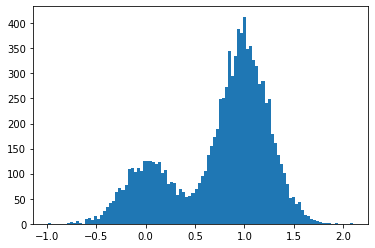

In [129]:
mean1 = 0.01
mean2 = 1
var = 0.25
beta_param = 0.25
bimodal_gaussian_dist = bimodal_gaussian(mean1, mean2, var, beta_param)

We will now use this distribution to sample the deltas and design an encoding schedule that lets your model retrieve effectively. 

The trivial solution is to shove all the encodings towards the back end of the encoding period. Let's try it. 

In [134]:
def tcm(schedule):
    success_sum = 0
    load_sum = 0
    num_iter = 100

    for i in range(num_iter):
        schedule_load = ENCODING_TIME / np.median(np.diff(schedule[:, 0]))
        encoding = np.zeros((N_ITEMS, N_WORLD_FEATURES + 1))

        world_m = np.array([1, 2, 1, 2, 3], dtype=float)
        world_var = 1
        m = 0

        for time in range(ENCODING_TIME):
            delta = rand.choice(bimodal_gaussian_dist)
            world_m += delta
            world = rand.normal(world_m, world_var)
            if m < N_ITEMS:
                if time == schedule[m, 0]:
                    encoding[m, :] = np.append(world, m)
                    m += 1

        out = np.zeros(TEST_TIME)
        while time < ENCODING_TIME + TEST_TIME:
            delta = rand.choice(bimodal_gaussian_dist)
            world_m += delta
            world = rand.normal(world_m, world_var)
            soa = np.zeros(N_ITEMS)
            for m in range(N_ITEMS):
                soa[m] = np.dot(encoding[m], np.append(world, m))
            soa /= np.linalg.norm(soa)
            out[time - ENCODING_TIME] = np.where(draw_from_a_dist(soa) > 0)[0]
            time += 1

        success = len(np.unique(out))
        success_sum += success
        load_sum += schedule_load

    avg_success = success_sum / num_iter
    avg_load = load_sum / num_iter
    print(f'Average success over {num_iter} iterations: {avg_success}')
    print(f'Average schedule load over {num_iter} iterations: {avg_load}')

In [135]:
schedule = np.column_stack((np.sort(np.arange(490, 500)), np.arange(N_ITEMS)))
tcm(schedule)

Average success over 100 iterations: 9.01
Average schedule load over 100 iterations: 500.0


Hence, our model is able to retrieve effectively even when the world contains context changes by shoving all the encodings towards the back end of the encoding period. But this increased the schedule load. 

Now, let's try to reduce the schedule load while keeping the success above 7. 

To do this, we will try to maximize the median of the intervals. To this this, we will shove the first 5 encodings towards the back and put the rest of the encodings with equal spaces before the first 5 encodings. 

In [136]:
l = [0, 99, 198, 297, 396, 495, 496, 497, 498, 499]
schedule = np.column_stack((l, np.arange(N_ITEMS)))
tcm(schedule)

Average success over 100 iterations: 7.66
Average schedule load over 100 iterations: 5.050505050505038


Now our model is able to retrieve effectively with minimum schedule load. 

### Part 3: 50 marks

Do the same thing, but this time assuming that the retrieving agent does not know the parameters of the world generating model, just the fact that the rate of drift is sampled from a bimodal distribution. Hint: you'll have to have the agent learn the drift distribution parameters. EM is your friend here. 

We will use the EM algorithm to learn the parameters of the bimodal distribution. 

Again, let's first try shoving all the encodings towards the back end of the encoding period. 

In [137]:
def tcm_em(schedule):
    success_sum = 0
    load_sum = 0
    num_iter = 100
    deltas = []

    for i in range(num_iter):
        schedule_load = ENCODING_TIME / np.median(np.diff(schedule[:, 0]))
        encoding = np.zeros((N_ITEMS, N_WORLD_FEATURES + 1))

        world_m = np.array([1, 2, 1, 2, 3], dtype=float)
        world_var = 1
        m = 0

        for time in range(ENCODING_TIME):
            delta = rand.choice(bimodal_gaussian_dist)
            deltas.append([delta])
            world_m += delta
            world = rand.normal(world_m, world_var)
            if m < N_ITEMS:
                if time == schedule[m, 0]:
                    encoding[m, :] = np.append(world, m)
                    m += 1
        
        # Use the EM algorithm to learn the parameters of the bimodal distribution
        gm = GaussianMixture(n_components=2, random_state=0).fit(deltas)

        out = np.zeros(TEST_TIME)
        while time < ENCODING_TIME + TEST_TIME:
            delta = gm.sample()[0][0][0]
            world_m += delta
            world = rand.normal(world_m, world_var)
            soa = np.zeros(N_ITEMS)
            for m in range(N_ITEMS):
                soa[m] = np.dot(encoding[m], np.append(world, m))
            soa /= np.linalg.norm(soa)
            out[time - ENCODING_TIME] = np.where(draw_from_a_dist(soa) > 0)[0]
            time += 1

        success = len(np.unique(out))
        success_sum += success
        load_sum += schedule_load

    avg_success = success_sum / num_iter
    avg_load = load_sum / num_iter
    print(f'Average success over {num_iter} iterations: {avg_success}')
    print(f'Average schedule load over {num_iter} iterations: {avg_load}')

In [138]:
schedule = np.column_stack((np.sort(np.arange(490, 500)), np.arange(N_ITEMS)))
tcm_em(schedule)

Average success over 100 iterations: 8.74
Average schedule load over 100 iterations: 500.0


Hence, our model is able to retrieve effectively even when the retrieving agent does not know the parameters of the world generating model. 

Now, let's try to reduce the schedule load while keeping the success above 7 by using the optimal scheduling as described before. 

In [139]:
l = [0, 99, 198, 297, 396, 495, 496, 497, 498, 499]
schedule = np.column_stack((l, np.arange(N_ITEMS)))
tcm_em(schedule)

Average success over 100 iterations: 7.74
Average schedule load over 100 iterations: 5.050505050505038


Now our model is able to retrieve effectively with minimum schedule load. 